# Loading data

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [2]:
train_data = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-train-imgs.npz')['arr_0']
train_label = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-train-labels.npz')['arr_0']
test_data = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-test-imgs.npz')['arr_0']

print('train_data shape: {0}'.format(train_data.shape))
print('train_label shape: {0}'.format(train_label.shape))
print('test_data shape: {0}'.format(test_data.shape))

train_data shape: (654, 224, 224, 3)
train_label shape: (654,)
test_data shape: (497, 224, 224, 3)


## one-hot encoding

In [3]:
train_label = to_categorical(train_label)

print('train_label shape: {0}'.format(train_label.shape))

train_label shape: (654, 13)


In [4]:
train_data = train_data / 255.

print('train_data shape: {0}'.format(train_data.shape))

train_data shape: (654, 224, 224, 3)


# Preprocessing

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label,
                                                                test_size=0.2,
                                                                shuffle=True,
                                                                random_state=2021,
                                                                stratify=train_label,)

print('train_data shape: {0}, train_label shape: {1}'.format(train_data.shape, train_label.shape))
print('val_data shape: {0}, val_label shape: {1}'.format(val_data.shape, val_label.shape))

train_data shape: (523, 224, 224, 3), train_label shape: (523, 13)
val_data shape: (131, 224, 224, 3), val_label shape: (131, 13)


# Creating model

[tf-simple-metric-learning](https://pypi.org/project/tf-simple-metric-learning/)

In [7]:
!pip install --quiet tf-simple-metric-learning

In [8]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.applications import EfficientNetB0
from tf_simple_metric_learning.layers import AdaCos, CircleLossCL
from tensorflow.keras.models import Model
import tensorflow as tf

In [9]:
def creating_conv_base():
  img = Input(shape=(224, 224, 3))
  
  conv_base = EfficientNetB0(include_top=False, 
                             weights='imagenet',)
  _ = conv_base(img)
  _ = GlobalAveragePooling2D()(_)
  # _ = Dense(256, activation=None)(_)
  # _ = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(_)

  model = Model(inputs=[img], outputs=[_])

  return model

def creating_model(conv_base):
  
  img = Input(shape=(224, 224, 3))
  label = Input(shape=(13,))

  metric_layer = AdaCos(num_classes=13)

  _ = conv_base(img)
  output = metric_layer([_, label])
  
  model = Model(inputs=[img, label], outputs=[output])

  return model

# Building model

In [10]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

In [11]:
conv_base = creating_conv_base()
model = creating_model(conv_base)

optimizer = SGD(CosineDecay(initial_learning_rate=1e-2, 
                            decay_steps=50), 
                momentum=0.6,)
# optimizer = Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 1280)         4049571     input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
ada_cos (AdaCos)                (None, 13)           16641       model[0][0]                      
                                                                 input_4[0][0]              

In [12]:
from tensorflow.keras.utils import plot_model

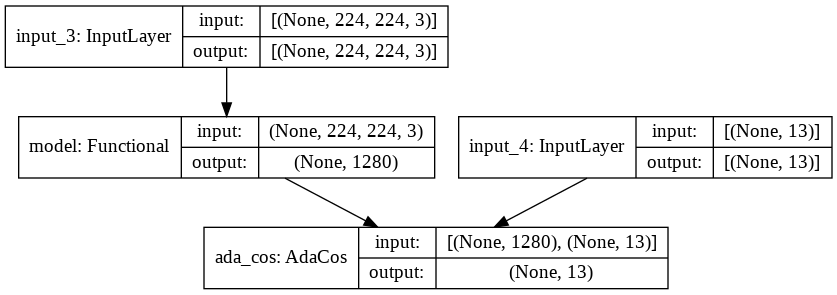

In [13]:
plot_model(model, show_shapes=True)

# Training

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from time import time

In [15]:
start_time = time()
history = model.fit([train_data, train_label], train_label,
                    epochs=50,
                    batch_size=4,
                    validation_data=([val_data, val_label], val_label,))
elapsed_time = time() - start_time

print('Elapsed time: {0:.3f} hrs'.format(elapsed_time / 3600))

Epoch 1/50
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
131/131 [==============================] - 18s 73ms/step - loss: 6.3308 - accuracy: 0.0841 - val_loss: 5.3335 - val_accuracy: 0.0611
Epoch 2/50
131/131 [==============================] - 8s 62ms/step - loss: 6.7443 - accuracy: 0.0612 - val_loss: 2.7709 - val_accuracy: 0.0916
Epoch 3/50
131/131 [==============================] - 8s 58ms/step - loss: 6.8999 - accuracy: 0.0650 - val_loss: 3.4888 - val_accuracy: 0.0763
Epoch 4/50
131/131 [==============================] - 8s 61ms/step - loss: 6.9571 - accuracy: 0.0650 - val_loss: 5.2679 - val_accuracy: 0.0916
Epoch 5/50
131/131 [==============================] - 8s 59ms/step - loss: 6.7453 - accuracy: 0.0516 - val_loss: 6.5458 - val_accuracy: 0.0687
Epoch 6/50
131/131 [==============================] - 8s 59ms/step - loss: 6.6615 - accuracy: 0.0554 - val_loss: 7.3253 - val_accuracy: 0.0687
Epo

# For visualization

[Tensorflow Embedding Projector](https://projector.tensorflow.org/)

In [16]:
# import io
# import numpy as np

# results = conv_base.predict(val_data)

# np.savetxt("vecs.tsv", results, delimiter='\t')

# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for label in np.argmax(val_label, axis=1).astype(int):
#   out_m.write(str(label) + "\n")
# out_m.close()

# try:
#   from google.colab import files
#   files.download('vecs.tsv')
#   files.download('meta.tsv')
# except:
#   pass

# End